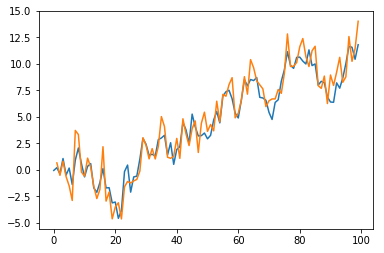

In [2]:
%matplotlib inline

from ssm.dglm import NormalDLM
from ssm.univariatestructure import UnivariateStructure
import numpy as np

lc = UnivariateStructure.locally_constant(1.4)

ndlm = NormalDLM(structure=lc, V=1.4)

# the initial state prior
m0 = np.array([0])
C0 = np.matrix([[1]])
state0 = np.random.multivariate_normal(m0, C0)

states = [state0]

for t in range(1, 100):
    states.append(ndlm.state(states[t-1]))
    
obs = [None]
for t in range(1, 100):
    obs.append(ndlm.observation(states[t]))
    
import matplotlib.pyplot as plt
plt.plot(range(100), states)
plt.plot(range(100), obs)